# $\textbf{Analysis of the}$ `'mobility_score'` $\textbf{ and definition of the actions}$

This Covid explainer will walk you through how to run the MDP Algorithm on the code (in the version used by `covid_team2`). Everything you need to run the code should already be here in this folder, as the MDP algorithm was modified for Covid specifically. Relevant files in this directory include: 
* `mdp_model.py`
* `mdp_clustering.py`
* `mdp_testing.py`
* `mdp_tools.py`
* `states_combined_data.csv`**

** Note: some rows or columns have been taken out to create this sample dataset, to accomodate missing data in the original dataset. 

## Creating Training Data

We will run one round of the demonstration that trains on data that ends at a date earlier than the last date we have on our dataset. This way we can compare how well our model predicts to the real value in our data. The last date in this `states_combined_data.csv` contains up to `5/29/20`. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load Built-in Modules
import pandas as pd
import numpy as np
from datetime import timedelta
import seaborn as sns
import os
import matplotlib.pyplot as plt
import pickle

# [not in the code for now]
from ml_war_machine.feature_engineering import feature_engineering as fe
from ml_war_machine.machine_learning import feature_selection as fs
from ml_war_machine.statistical_analysis import statistical_analysis as sta

# Ignore Python package warnings (not verbose)
import warnings
warnings.filterwarnings("ignore")

In [2]:
# paths
DIRECTORY_PATH = os.path.dirname(os.getcwd())
os.chdir(DIRECTORY_PATH)

DATA_PATH   = r"C:\Users\david\Dropbox (MIT)\COVID-19-Team2\Data"
RESULT_PATH = os.path.join(os.path.dirname(os.getcwd()), "results")
MODEL_PATH  = os.path.join(os.getcwd(), "models")

In [3]:
# # experiment name
# EXPERIMENT_FOLDER = "01 - Cross-validation by state"
# try: 
#     assert os.path.exists(os.path.join(RESULT_PATH, EXPERIMENT_FOLDER))
# except AssertionError:
#     os.mkdir(os.path.join(RESULT_PATH, EXPERIMENT_FOLDER))

In [4]:
# Load MDP packages
import codes.mdp_model as mdp
from codes.mdp_testing import mape, plot_pred
from codes.mdp_states_functions import createSamples

In [5]:
file = '07_16_2020_states_combined.csv'
df = pd.read_csv(os.path.join(DATA_PATH, file), parse_dates=["date"], index_col = 0)
df.rename(columns={"Population": "population"}, inplace=True)
df.head()

,state,date,cases,deaths,population,emergdec,schoolclose,barrestrict,gathrestrict25,gathrestrictany,...,workplaces,residential,recovered,active,incident_rate,people_tested,people_hospitalized,mortality_rate,testing_rate,hospitalization_rate
0,Alabama,2020-01-22,0,0,4903185.0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Alabama,2020-01-23,0,0,4903185.0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Alabama,2020-01-24,0,0,4903185.0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Alabama,2020-01-25,0,0,4903185.0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Alabama,2020-01-26,0,0,4903185.0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Exception
df = df[df["state"]!='Guam']
df = df[df["state"]!='Northern Mariana Islands']
df = df[df["state"]!='Puerto Rico']
df = df[df["state"]!='Diamond Princess']
df = df[df["state"]!='Grand Princess']
df = df[df["state"]!='American Samoa']
df = df[df["state"]!='Virgin Islands']

In [13]:
feature = "mobility_score"

df.dropna(subset=["population"], inplace=True)
df["cases_nom"] = df["cases"] / df["population"]
df["deaths_nom"] = df["deaths"] / df["population"]
df["cases_pct3"] = df.groupby("state")["cases"].pct_change(3)
df["cases_pct5"] = df.groupby("state")["cases"].pct_change(5)

df.replace([np.inf, -np.inf], np.nan, inplace=True)

try:
    dfs = []

    for group_id, group in df.groupby("state", as_index=False):
        try:
            dfs.append(group[group.index < group[group[feature].isnull()].index.values[-1]])
        except IndexError:
            dfs.append(group)
        df = pd.concat(dfs)
    
    feature = "mobility_score"
#     df["{}_pct".format(feature)] = df.groupby("state")[feature].pct_change()

#     df.dropna(subset=["{}_pct".format(feature)], inplace=True)
    
except KeyError:
    pass

df.to_csv(os.path.join(DATA_PATH, file.replace(".csv", "_w_pct.csv")), index=True)

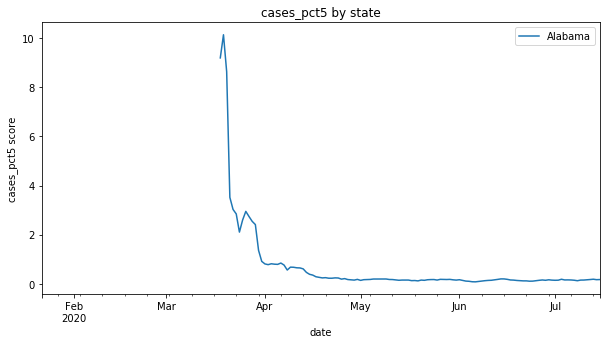

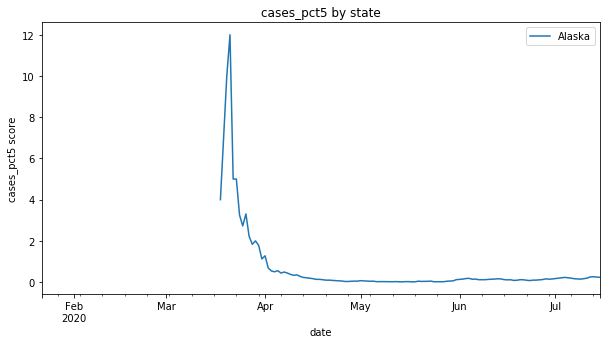

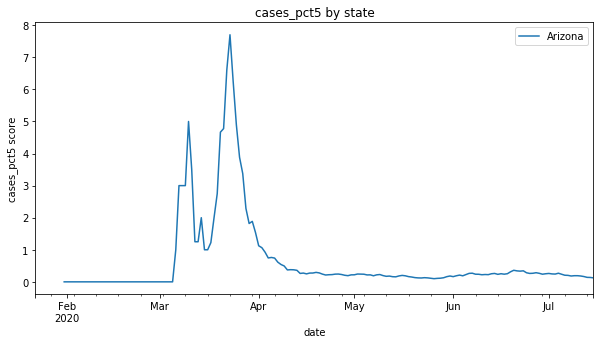

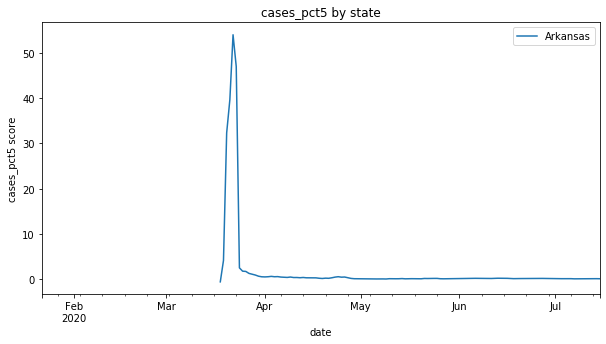

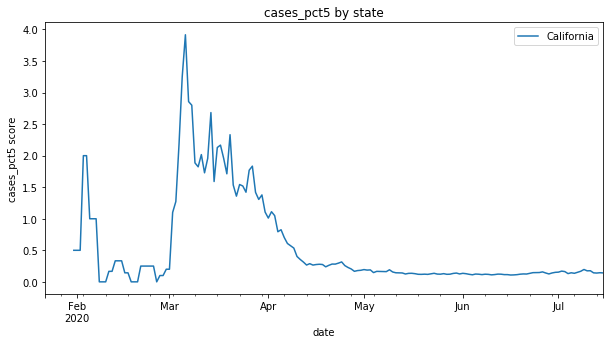

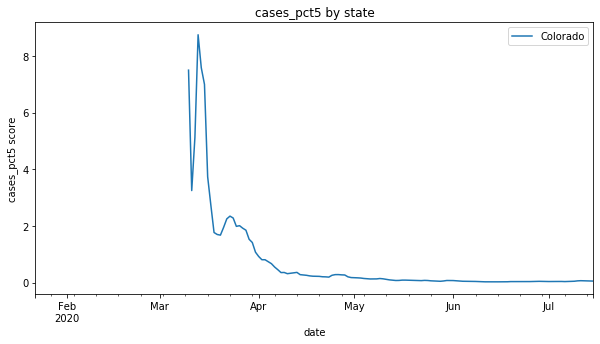

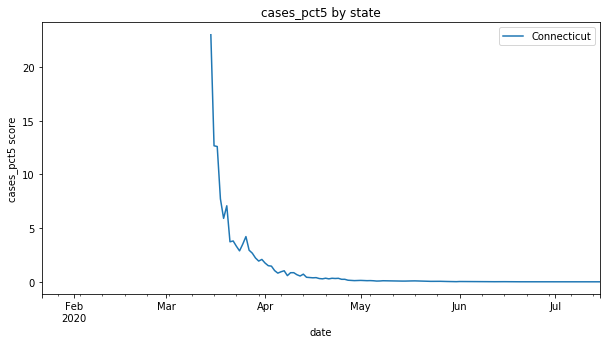

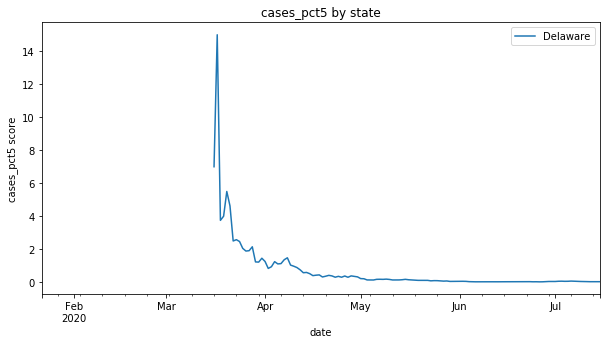

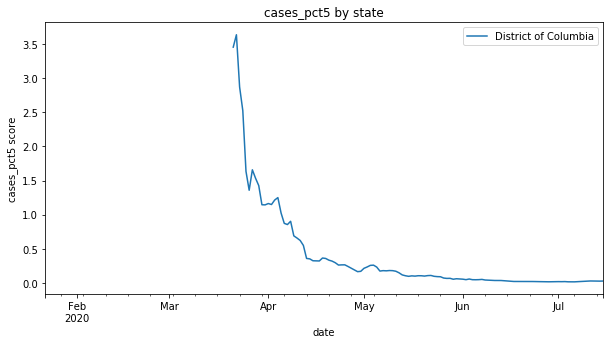

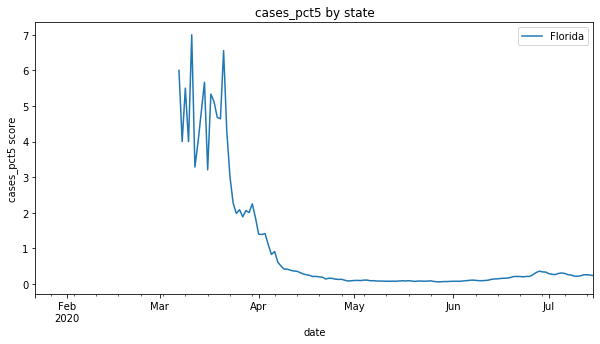

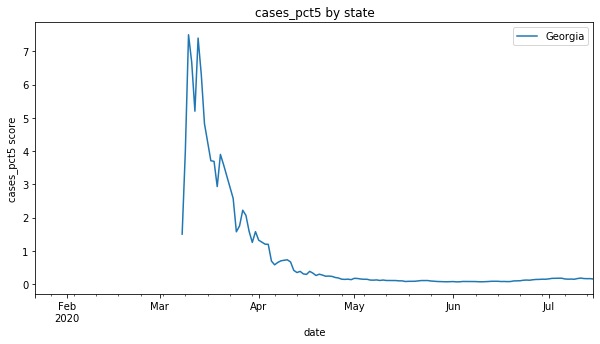

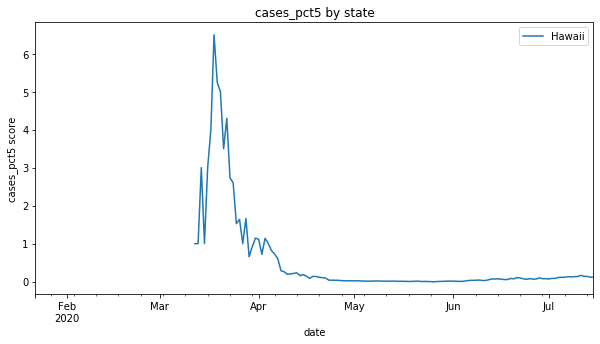

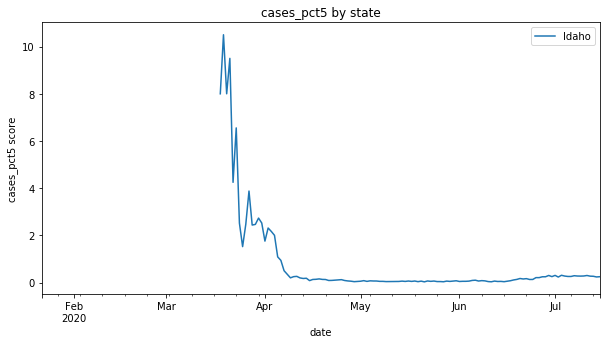

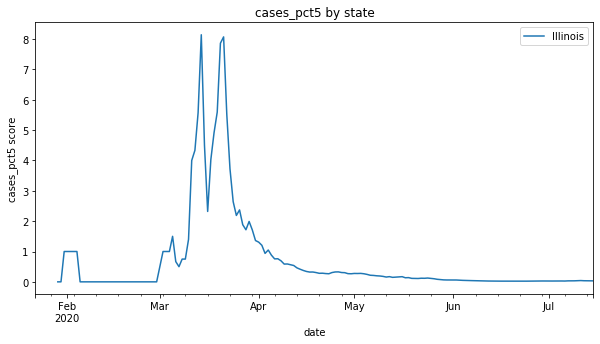

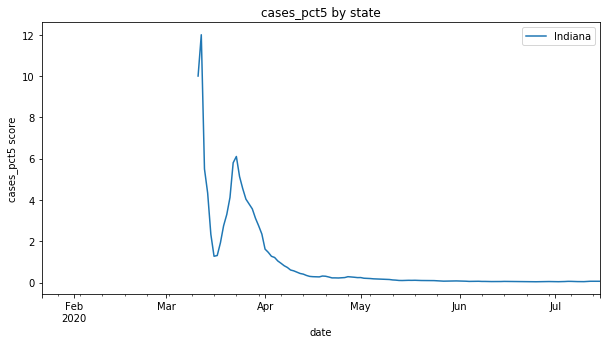

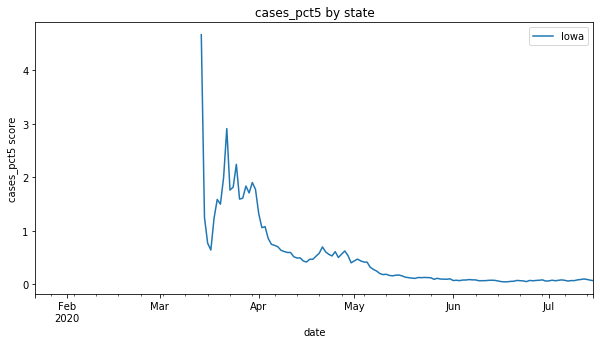

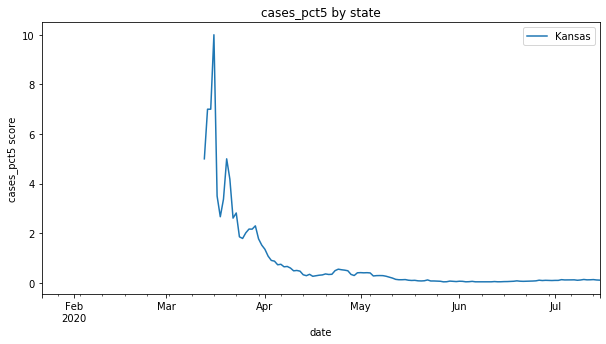

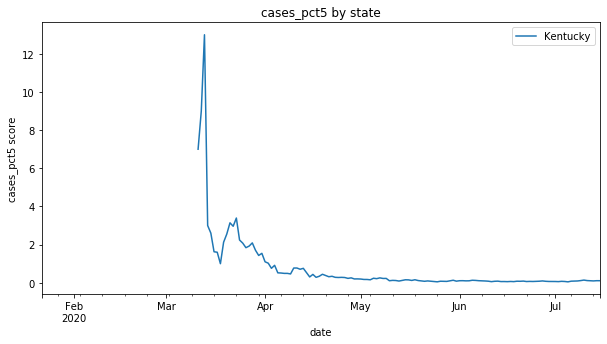

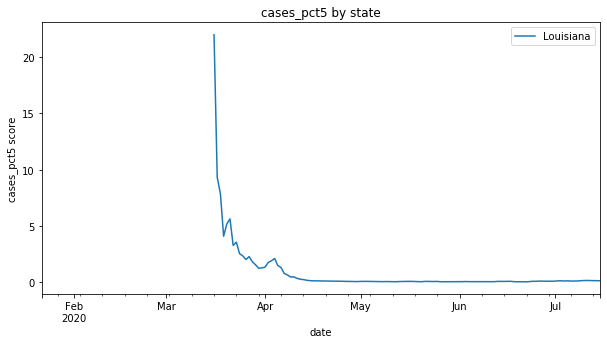

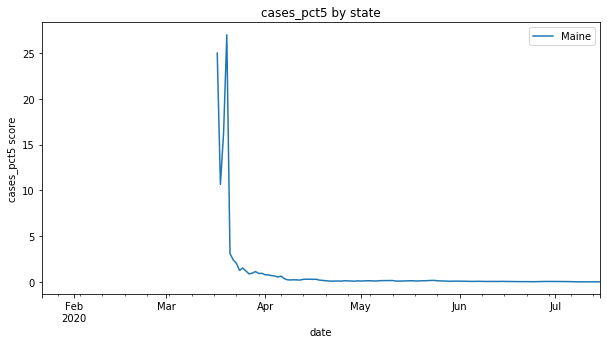

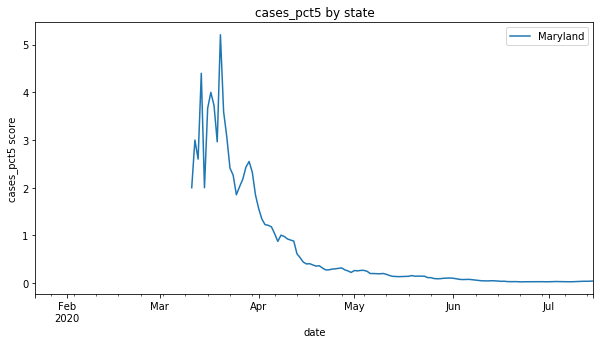

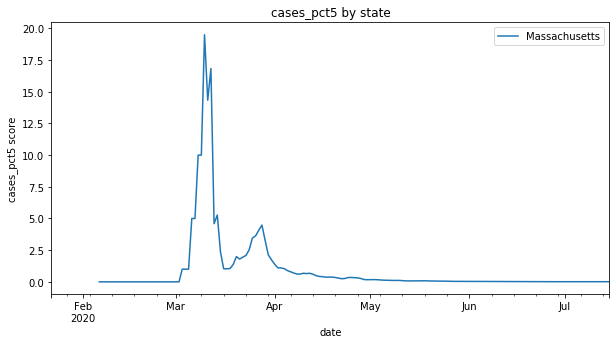

In [11]:
# plotting for a specific feature by region

feature = "cases_pct5"
for id_, (name, group) in enumerate(df.groupby("state")):
    group.plot(x="date", y=feature, label=name)
    plt.title("cases_pct5 by state")
    plt.ylabel("cases_pct5 score")
    if id_ > 20 :
        break
plt.legend()
plt.show()

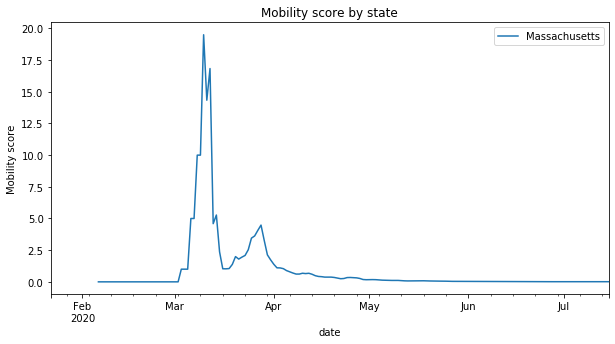

In [12]:
# plotting for a specific feature by region

feature = "cases_pct5"
state_id = "Massachusetts"
df[df.state == state_id].plot(x="date", y=feature, label=state_id)
plt.title("Mobility score by state")
plt.ylabel("Mobility score")
plt.legend()
plt.show()

### $\textbf{Seasonal Decomposition of the percentage change in mobility score }$ 

ADF Statistic: -0.7784237603114208
p-value: 0.8253779170110402
Critial Values:
   1%, -3.489057523907491
Critial Values:
   5%, -2.887246327182993
Critial Values:
   10%, -2.5804808802708528


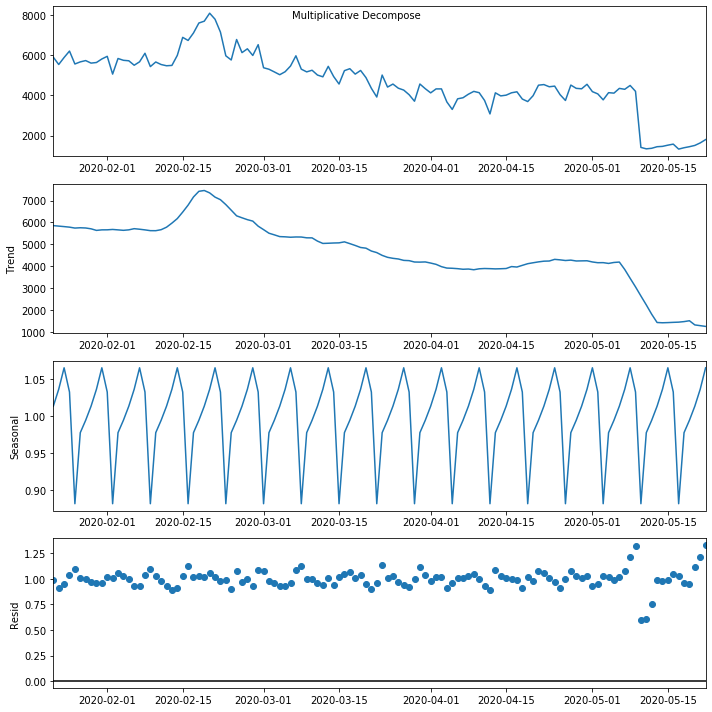

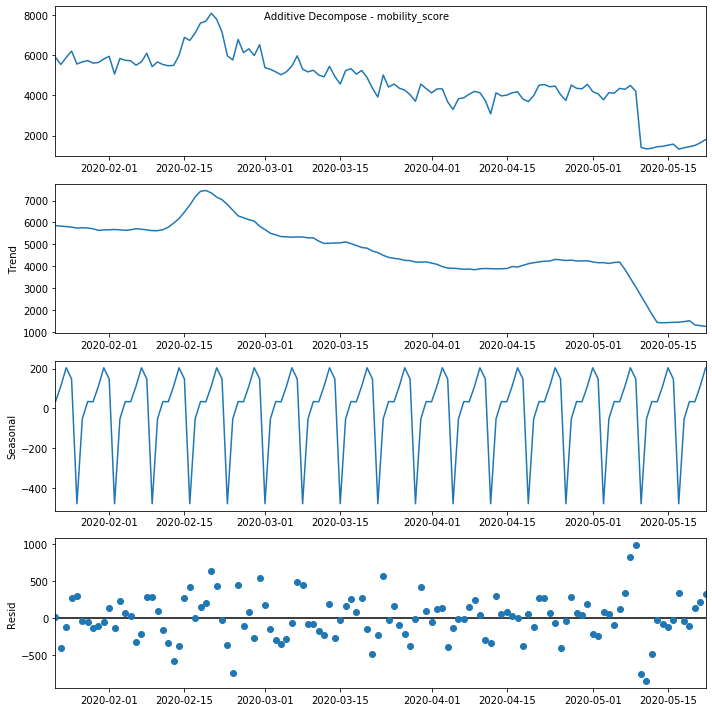

In [10]:
sta.seasonality_analysis(df[(df.state == "Massachusetts")], col="mobility_score", 
                         date_index="date", index=None, freq="1D", test="ADF", disp_plot=True)

In [11]:
# # # for all state
# sta.seasonality_analysis(df, col="mobility_score", 
#                          date_index="date", index="state", freq="1D", test="ADF", disp_plot=True)

## $\textbf{Add the}$ `'Mobility_score'` $\textbf{seasonal decomposition to the dataset}$

In [12]:
feature = "mobility_score"
df = fe.seasonality_decomp(df, cols=[feature], date_index="date", index="state", mode="additive", freq="1D")
df["{}_trend_pct".format(feature)] = df.groupby("state")["{}_trend".format(feature)].pct_change()
df["{}_trend_diff".format(feature)] = df.groupby("state")["{}_trend".format(feature)].diff()
df.dropna(subset=["{}_trend_pct".format(feature), "{}_trend_diff".format(feature)], inplace=True)
df.head()

,date,state,cases,deaths,population,emergdec,schoolclose,gathrestrict25,gathrestrictany,otherbusinessclose,...,mobility_score,cases_nom,deaths_nom,cases_pct3,cases_pct5,mobility_score_seas,mobility_score_trend,mobility_score_resid,mobility_score_trend_pct,mobility_score_trend_diff
1,2020-01-23,Alabama,0,0,4903185.0,0,0,0,0,0,...,9057.0,0.0,0.0,NaN,NaN,142.766021,9129.627551,-215.393572,-0.003463,-31.729592
2,2020-01-24,Alabama,0,0,4903185.0,0,0,0,0,0,...,9247.0,0.0,0.0,NaN,NaN,430.040114,9097.897959,-280.938073,-0.003475,-31.729592
3,2020-01-25,Alabama,0,0,4903185.0,0,0,0,0,0,...,9830.0,0.0,0.0,NaN,NaN,669.688640,9042.142857,118.168503,-0.006128,-55.755102
4,2020-01-26,Alabama,0,0,4903185.0,0,0,0,0,0,...,7953.0,0.0,0.0,NaN,NaN,-532.248402,9004.857143,-519.608741,-0.004124,-37.285714
5,2020-01-27,Alabama,0,0,4903185.0,0,0,0,0,0,...,8901.0,0.0,0.0,NaN,NaN,-683.248402,9021.714286,562.534116,0.001872,16.857143


In [13]:
df.to_csv(os.path.join(DATA_PATH, file.replace(".csv", "_w_trend.csv")), index=True)

## $\textbf{Plotting the trend mobility by states}$

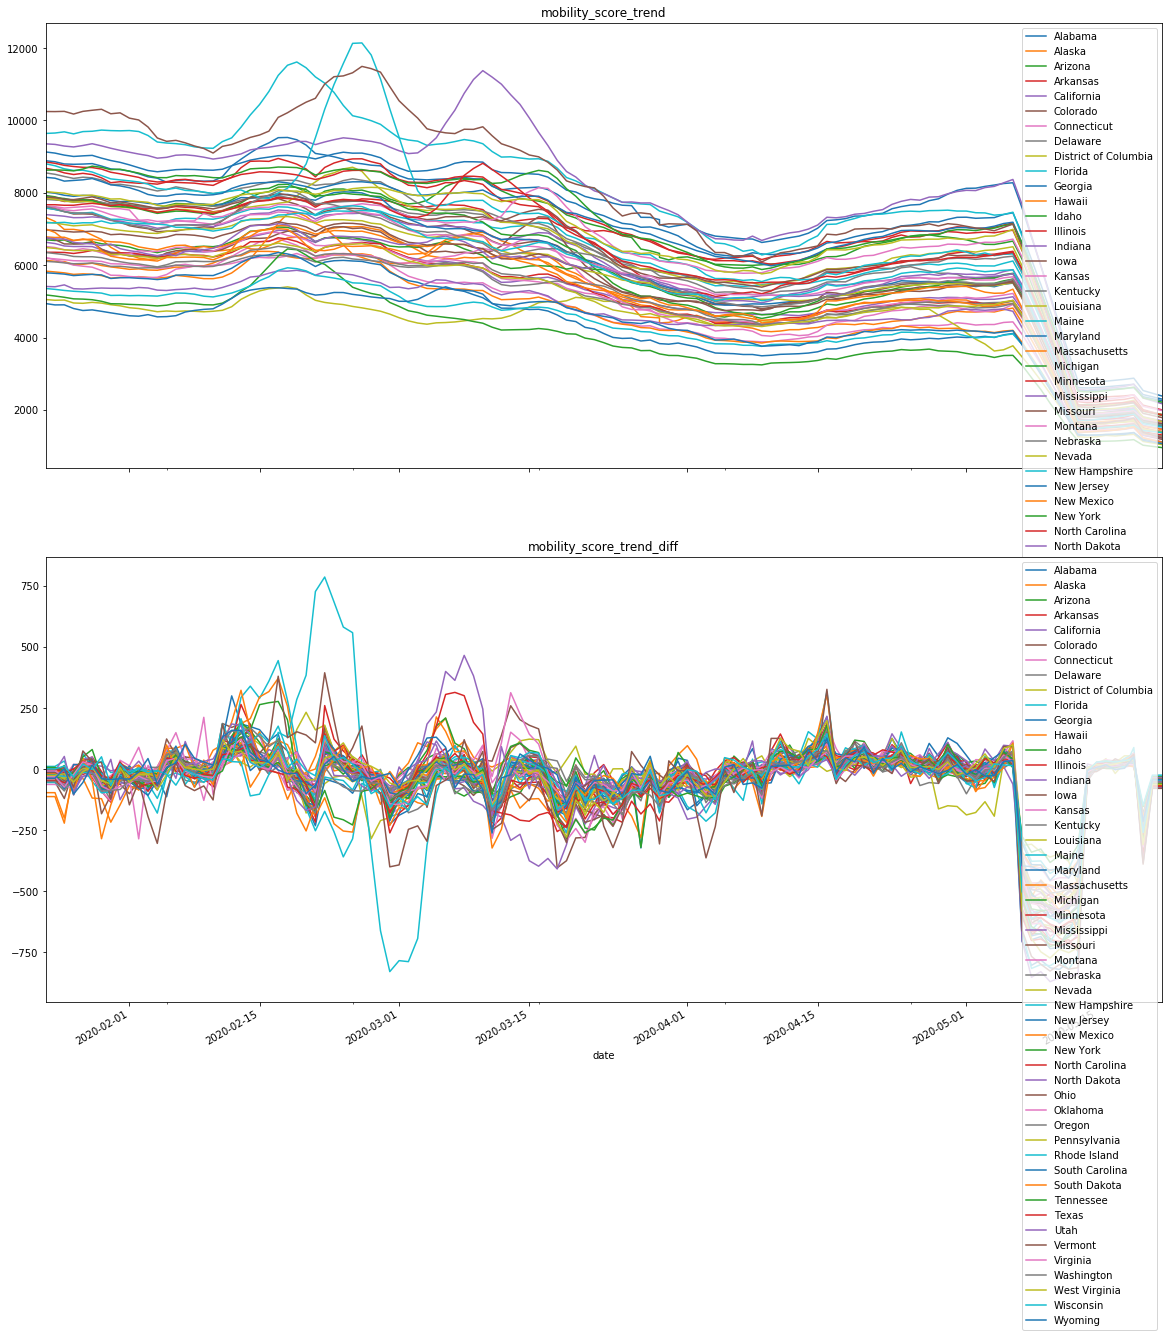

In [14]:
features = "mobility_score"
fig, (ax1, ax2) = plt.subplots(figsize=(20,20), nrows=2, sharex=True)
for id_, (label, group) in enumerate(df.groupby("state")):
    group["{}_trend_resid".format(features)] = group["{}_trend".format(features)] + group["{}_resid".format(features)]
    group.plot(x="date", y="{}_trend".format(features), ax=ax1, label=label, title="{}_trend".format(features))
#     if id_ > 20:
#         break
for id_, (label, group) in enumerate(df.groupby("state")):
    group.plot(x="date", y="{}_trend_diff".format(features), ax=ax2, label=label, title="{}_trend_diff".format(features))
#     if id_ > 20:
#         break
plt.show()

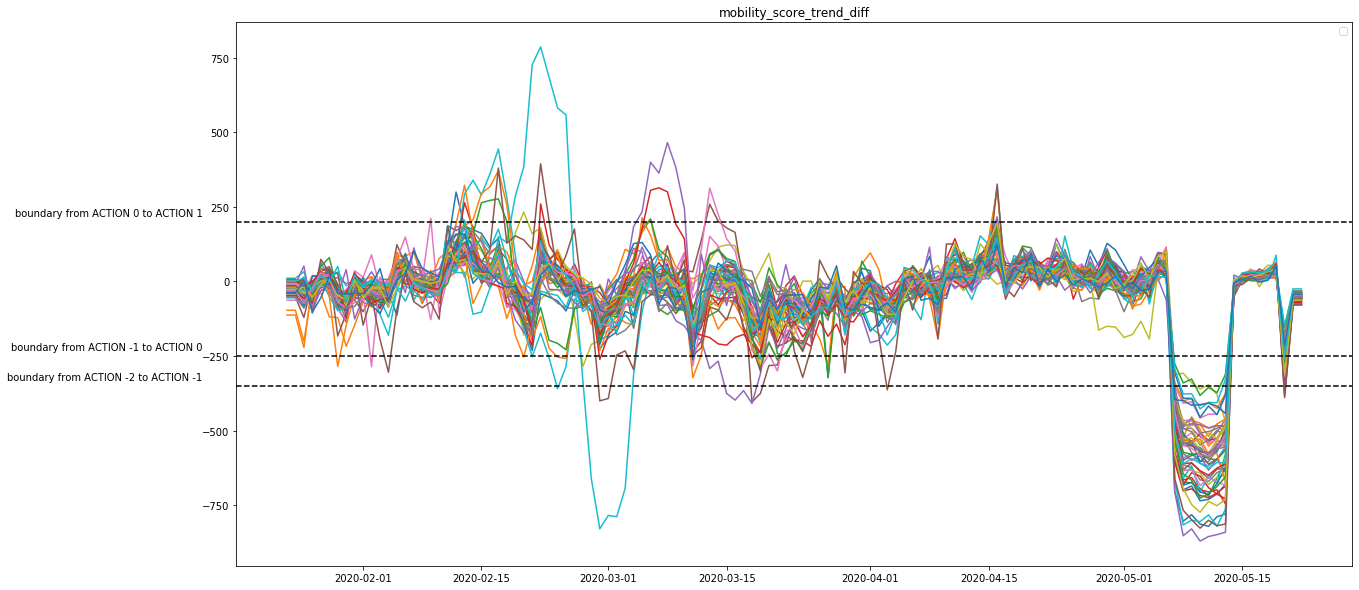

In [15]:
features = "mobility_score"
action_thresh = ([-350, -250, 200], 2)

fig, ax = plt.subplots(figsize=(20,10), nrows=1, sharex=True)
for id_, (label, group) in enumerate(df.groupby("state")):
    ax.plot(group["date"], group["{}_trend_diff".format(features)])
#     if id_ > 20:
#         break
for idx, action in enumerate(action_thresh[0]):
    ax.axhline(action, color='k', linestyle='--')
    ax.text(group["date"].min()-timedelta(10),action+20,'boundary from ACTION {} to ACTION {}'.format(idx -action_thresh[1], idx -action_thresh[1]+1),
            horizontalalignment='right')
plt.title("{}_trend_diff".format(features))
plt.legend()
plt.show()


We can specify a value `n_days` to create a training dataset that ends `n_days` before this last date. We will also need to give the name of the date column from our `df`. 

In [16]:
n_days = 15
date_col = 'date'

# take out dates for prediction
df.loc[:, [date_col]]= pd.to_datetime(df[date_col])
split_date = df[date_col].max() - timedelta(n_days)
df_train = df.loc[df[date_col] <= split_date]
df_train

,date,state,cases,deaths,population,emergdec,schoolclose,gathrestrict25,gathrestrictany,otherbusinessclose,...,mobility_score,cases_nom,deaths_nom,cases_pct3,cases_pct5,mobility_score_seas,mobility_score_trend,mobility_score_resid,mobility_score_trend_pct,mobility_score_trend_diff
1,2020-01-23,Alabama,0,0,4903185.0,0,0,0,0,0,...,9057.0,0.000000,0.000000,NaN,NaN,142.766021,9129.627551,-215.393572,-0.003463,-31.729592
2,2020-01-24,Alabama,0,0,4903185.0,0,0,0,0,0,...,9247.0,0.000000,0.000000,NaN,NaN,430.040114,9097.897959,-280.938073,-0.003475,-31.729592
3,2020-01-25,Alabama,0,0,4903185.0,0,0,0,0,0,...,9830.0,0.000000,0.000000,NaN,NaN,669.688640,9042.142857,118.168503,-0.006128,-55.755102
4,2020-01-26,Alabama,0,0,4903185.0,0,0,0,0,0,...,7953.0,0.000000,0.000000,NaN,NaN,-532.248402,9004.857143,-519.608741,-0.004124,-37.285714
5,2020-01-27,Alabama,0,0,4903185.0,0,0,0,0,0,...,8901.0,0.000000,0.000000,NaN,NaN,-683.248402,9021.714286,562.534116,0.001872,16.857143
6,2020-01-28,Alabama,0,0,4903185.0,0,0,0,0,0,...,9010.0,0.000000,0.000000,NaN,NaN,-63.676973,9035.285714,38.391259,0.001504,13.571429
7,2020-01-29,Alabama,0,0,4903185.0,0,0,0,0,0,...,9036.0,0.000000,0.000000,NaN,NaN,36.679003,8958.285714,41.035283,-0.008522,-77.000000
8,2020-01-30,Alabama,0,0,4903185.0,0,0,0,0,0,...,9175.0,0.000000,0.000000,NaN,NaN,142.766021,8892.571429,139.662551,-0.007336,-65.714286
9,2020-01-31,Alabama,0,0,4903185.0,0,0,0,0,0,...,9342.0,0.000000,0.000000,NaN,NaN,430.040114,8842.000000,69.959886,-0.005687,-50.571429
10,2020-02-01,Alabama,0,0,4903185.0,0,0,0,0,0,...,9291.0,0.000000,0.000000,NaN,NaN,669.688640,8772.428571,-151.117211,-0.007868,-69.571429


## Creating Samples

Usually at this point we will set all the parameters that we use to run `model.fit`, but first I want to show you how the actual training samples are created from the data given (which usually happens within `model.fit`). 

Now this is a very important part! We need to specify a `target` value that our model aims to predict from the training data. The few other things we have to specify include `date_col`, `region_col` and `feature_cols`. `region_col` is the name of the area we are measuring, such as `'state'`, while `feature_cols` are a list of strings we want to use as features, such as `['mobility_score_trend']`. 

`d_avg` is the number of days we want to average when creating each datapoint, which can help decrease noise if there is a sudden spike in cases at a certain day. 

In [17]:
# Setting parameters
target_colname = 'deaths'
region_colname = 'state'
date_colname = 'date'
feature_cols = ["mobility_score_trend", "cases_pct3", "cases_pct5"]  # action with no features
days_avg = 1

#### Without including actions

The other parameters relevant to creating samples include an `action_thresh`, which is a list of ints that create cutoff brackets for actions. When `action_thresh` is an empty list `([], 0)`, the default `ACTION = 0` for all datapoints. For example (the other features will be explained below too!):

In [18]:
action_thresh = ([], 0)
df_samples, pfeatures = createSamples(df, target_colname, region_colname, date_colname, feature_cols, action_thresh, days_avg)
df_samples

,ID,TIME,mobility_score_trend,cases_pct3,cases_pct5,mobility_score_trend-1,mobility_score_trend-2,cases_pct3-1,cases_pct3-2,cases_pct5-1,cases_pct5-2,r_t,r_t-1,r_t-2,RISK,ACTION,state,deaths
0,0,2020-03-27,7323.000000,1.425620,2.738854,7645.571429,7657.142857,1.637755,1.426752,2.946565,2.594340,4.000000,1.0,1.0,1.386294,0,Alabama,4
1,0,2020-03-28,7320.142857,0.821522,2.540816,7323.000000,7645.571429,1.425620,1.637755,2.738854,2.946565,1.000000,4.0,1.0,0.000000,0,Alabama,4
2,0,2020-03-29,7190.857143,0.500598,1.787223,7320.142857,7323.000000,0.821522,1.425620,2.540816,2.738854,2.500000,4.0,4.0,0.916291,0,Alabama,10
3,0,2020-03-30,7051.142857,0.295389,0.738878,7190.857143,7320.142857,0.500598,0.821522,1.787223,2.540816,1.000000,10.0,4.0,0.000000,0,Alabama,10
4,0,2020-03-31,7095.857143,0.196364,0.681431,7051.142857,7190.857143,0.295389,0.500598,0.738878,1.787223,2.300000,10.0,10.0,0.832909,0,Alabama,23
5,0,2020-04-01,7131.285714,0.284848,0.527378,7095.857143,7051.142857,0.196364,0.295389,0.681431,0.738878,1.173913,23.0,10.0,0.160343,0,Alabama,27
6,0,2020-04-02,6981.285714,0.371524,0.494545,7131.285714,7095.857143,0.284848,0.196364,0.527378,0.681431,1.185185,27.0,23.0,0.169899,0,Alabama,32
7,0,2020-04-03,6873.428571,0.514691,0.812121,6981.285714,7131.285714,0.371524,0.284848,0.494545,0.527378,1.187500,32.0,27.0,0.171850,0,Alabama,38
8,0,2020-04-04,6803.142857,0.522642,0.795328,6873.428571,6981.285714,0.514691,0.371524,0.812121,0.494545,1.157895,38.0,32.0,0.146603,0,Alabama,44
9,0,2020-04-05,6779.857143,0.431468,0.788247,6803.142857,6873.428571,0.522642,0.514691,0.795328,0.812121,1.022727,44.0,38.0,0.022473,0,Alabama,45


#### After including actions on `'mobility_score_trend'`

Now, if we specify `action_thresh` to be these cutoff bins, `([-350, -250, 200], 2)`, these 6 numbers in the `action_thresh` delineate the start and end range of each `ACTION`, so we will be creating `4` actions total, and the specified action corresponding to `no action` is the `{0 : [-250, 200]}`. The ranges are for the `feature_change` of the first feature in the list `feature_cols`. This `feature_change` corresponds to the `t-1` - `t-2` values of this first feature in the list. So for instance in this dataset and the above `action_thresh` with `feature_cols = ['mobility_score_trend']`, `feature_cols[0] = 'mobility_score_trend'`: if the `mobility_score_trend_change = -275` for a certain datapoint, it will be assigned `ACTION=-1` (since it is in the second bracket). 

Make sure you set `action_thresh` to encompass the entire range of possible `feature_change` values! What you choose to put as the action-determining feature (listed first in `features_cols`) and where action bin cutoffs are will of course have a big impact on how the model learns the MDP. 

In [19]:
action_thresh = ([-350, -250, 200], 2)
df_samples, pfeatures = createSamples(df, target_colname, region_colname, date_colname, feature_cols, action_thresh, days_avg)
df_samples

,ID,TIME,mobility_score_trend,cases_pct3,cases_pct5,mobility_score_trend-1,mobility_score_trend-2,cases_pct3-1,cases_pct3-2,cases_pct5-1,cases_pct5-2,r_t,r_t-1,r_t-2,RISK,mobility_score_trend_change,ACTION,state,deaths
0,0,2020-03-27,7323.000000,1.425620,2.738854,7645.571429,7657.142857,1.637755,1.426752,2.946565,2.594340,4.000000,1.0,1.0,1.386294,-11.571429,0,Alabama,4
1,0,2020-03-28,7320.142857,0.821522,2.540816,7323.000000,7645.571429,1.425620,1.637755,2.738854,2.946565,1.000000,4.0,1.0,0.000000,-322.571429,-1,Alabama,4
2,0,2020-03-29,7190.857143,0.500598,1.787223,7320.142857,7323.000000,0.821522,1.425620,2.540816,2.738854,2.500000,4.0,4.0,0.916291,-2.857143,0,Alabama,10
3,0,2020-03-30,7051.142857,0.295389,0.738878,7190.857143,7320.142857,0.500598,0.821522,1.787223,2.540816,1.000000,10.0,4.0,0.000000,-129.285714,0,Alabama,10
4,0,2020-03-31,7095.857143,0.196364,0.681431,7051.142857,7190.857143,0.295389,0.500598,0.738878,1.787223,2.300000,10.0,10.0,0.832909,-139.714286,0,Alabama,23
5,0,2020-04-01,7131.285714,0.284848,0.527378,7095.857143,7051.142857,0.196364,0.295389,0.681431,0.738878,1.173913,23.0,10.0,0.160343,44.714286,0,Alabama,27
6,0,2020-04-02,6981.285714,0.371524,0.494545,7131.285714,7095.857143,0.284848,0.196364,0.527378,0.681431,1.185185,27.0,23.0,0.169899,35.428571,0,Alabama,32
7,0,2020-04-03,6873.428571,0.514691,0.812121,6981.285714,7131.285714,0.371524,0.284848,0.494545,0.527378,1.187500,32.0,27.0,0.171850,-150.000000,0,Alabama,38
8,0,2020-04-04,6803.142857,0.522642,0.795328,6873.428571,6981.285714,0.514691,0.371524,0.812121,0.494545,1.157895,38.0,32.0,0.146603,-107.857143,0,Alabama,44
9,0,2020-04-05,6779.857143,0.431468,0.788247,6803.142857,6873.428571,0.522642,0.514691,0.795328,0.812121,1.022727,44.0,38.0,0.022473,-70.285714,0,Alabama,45


Finally, `pfeatures` is the number of features that are used for training, which starts at the target column and ends before the RISK column. Essentially, it is the target, features, and ratio, for the current time point as well as its history `t-1` and `t-2`. 

In [20]:
pfeatures

12